<a href="https://colab.research.google.com/github/malraharsh/Image-Captioning/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''


'''

In [2]:
import numpy as np
# from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
import glob
import pickle 
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [3]:
%%capture

!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip Flickr8k_Dataset.zip

!mkdir textFiles
!unzip Flickr8k_text.zip -d /content/textFiles

!rm -r sample_data
!rm -r __MACOSX/

In [4]:
# import glob

# for i in glob.glob('*.txt'):
#     !rm $i

In [5]:
def load_file(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [6]:
doc = load_file('/content/textFiles/Flickr8k.token.txt')

In [7]:
print(doc[:200])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A lit


In [8]:
import os

In [9]:
def load_descriptions(file):
    info = {}

    for line in file.split('\n'):
        if len(line) <= 1:
            continue
        
        img_id, img_descr = line.split('\t')
        
        if not os.path.isfile(path_img_data + img_id[:-2]): #removes images not present
            continue
        
        img_id = img_id.split('.')[0]

        if img_id not in info:
            info[img_id] = list()
        info[img_id].append(img_descr)

    return info

In [11]:
path_img_data = '/content/Flicker8k_Dataset/'
path_text = '/content/textFiles/'

In [12]:
descriptions = load_descriptions(doc)
list(descriptions.items())[:3]

[('1000268201_693b08cb0e',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .']),
 ('1001773457_577c3a7d70',
  ['A black dog and a spotted dog are fighting',
   'A black dog and a tri-colored dog playing with each other on the road .',
   'A black dog and a white dog with brown spots are staring at each other in the street .',
   'Two dogs of different breeds looking at each other on the road .',
   'Two dogs on pavement moving toward each other .']),
 ('1002674143_1b742ab4b8',
  ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
   'A little girl is sitting in front of a large painted rainbow .',
   'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it

In [13]:
# n = 3
# i = 0

# fix, ax = plt.subplots(n, 1, figsize=(25, 25))
# # ax.flatten()

# for (img_filename, img_descr) in list(descriptions.items())[:n]:
#     img_file = plt.imread('/content/Flicker8k_Dataset/' + img_filename + '.jpg')
#     ax[i].imshow(img_file)
#     print(' /n'.join(img_descr))
#     i += 1

In [14]:
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# print(stopwords.words('english'))

In [29]:
import string

def clean_sentence(sent):
    words = sent.split()
    words = map(str.lower, words)
    words = [w for w in words if len(w) > 1]
    words = [w for w in words if w.isalpha()] 
    words = 'startseq' + ' '.join(words) + ' endseq'  
    return words

def clean_descriptions(file):
    table = str.maketrans('', '', string.punctuation) #intab, outtab, toremove string, outtab replace intab

    for key, desc_list in descriptions.items():
        for idx, desc in enumerate(desc_list):
            desc_list[idx] = clean_sentence(desc)

clean_descriptions(descriptions)

In [16]:
descriptions['1001773457_577c3a7d70']

['startseqblack dog and spotted dog are fighting endseq',
 'startseqblack dog and dog playing with each other on the road endseq',
 'startseqblack dog and white dog with brown spots are staring at each other in the street endseq',
 'startseqtwo dogs of different breeds looking at each other on the road endseq',
 'startseqtwo dogs on pavement moving toward each other endseq']

In [17]:
list(descriptions.items())[:1]

[('1000268201_693b08cb0e',
  ['startseqchild in pink dress is climbing up set of stairs in an entry way endseq',
   'startseqgirl going into wooden building endseq',
   'startseqlittle girl climbing into wooden playhouse endseq',
   'startseqlittle girl climbing the stairs to her playhouse endseq',
   'startseqlittle girl in pink dress going into wooden cabin endseq'])]

In [18]:
import json

json.dump(descriptions, open('descriptions.txt', 'w'))
# json.load(descriptions, open('descriptions.txt', 'r'))

In [19]:
train_images_path = load_file('/content/textFiles/Flickr_8k.trainImages.txt')
test_images_path = load_file('/content/textFiles/Flickr_8k.testImages.txt')

In [20]:
train_images_path[:100]

'2513260012_03d33305cf.jpg\n2903617548_d3e38d7f88.jpg\n3338291921_fe7ae0c8f8.jpg\n488416045_1c6d903fe0.j'

In [77]:
def create_images_list(imgnames, source=path_img_data):
    images = list()

    for img in imgnames.split('\n'):
        images.append(img)

    return images

train_images = create_images_list(train_images_path)
test_images = create_images_list(test_images_path)

In [22]:
from PIL import Image

img_shape = (299, 299)

def preprocess(img_path):
    img = image.load_img(img_path, target_size=img_shape)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

Using TensorFlow backend.


In [24]:
base_model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 4s 0us/step


In [64]:
#!!!!!
n_sample = 10
train_images = train_images[:n_sample]
test_images = test_images[:n_sample]

In [26]:
modelv3 = Model(base_model.input, base_model.layers[-2].output)

In [89]:
def encode(img_name):
    img_path = path_img_data + img_name

    if not os.path.isfile(img_path):
        return None
        
    img = preprocess(img_path)
    encoded_img = modelv3.predict(img)
    encoded_img = np.squeeze(encoded_img)
    return encoded_img

    
encoded_images_dict = lambda paths: {k: v for k, v in 
                                     {imgpath:encode(imgpath) for imgpath in paths}.items()
                                     if v is not None} # to remove None


encoded_train_images = encoded_images_dict(train_images)
print('done')
encoded_test_images = encoded_images_dict(test_images)  

done


In [79]:
a = train_images.copy()

In [80]:
a = np.array(a)

In [90]:
import os

dir_path = 'Pickle'
if not os.path.isdir(dir_path):
    os.mkdir(dir_path)

In [91]:
def save_images_pkl(data, path):
    path = 'Pickle/' + path
    with open(path, 'wb') as file:
        pickle.dump(data, file)

def load_images_pkl(path): # not working
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

save_images_pkl(encoded_train_images, 'encoded_train_images.pkl')
save_images_pkl(encoded_test_images, 'encoded_test_images.pkl')

In [92]:
captions = np.reshape(list(descriptions.values()), -1) # 2D descr in flattened list of captions
len(captions)

40455

In [ ]:
def show3(var):
    return list(var)[:3]

In [93]:
words_count = {}
word_count_thresh = 10

for line in captions:
    for word in line.split(' '):
        words_count[word] = words_count.get(word, 0) + 1 # 0 if no word

vocab = [w for w, count in words_count.items() if count >= word_count_thresh]        

In [94]:
print("Processed words from {} -> {}".format(len(words_count), len(vocab)))

Processed words from 9258 -> 2050


In [95]:
idx2word = {}
word2idx = {}

for idx, w in enumerate(vocab, 1):
    word2idx[w] = idx
    idx2word[idx] = w

In [96]:
size_vocab = len(vocab) + 1 # for appended 0
size_vocab

2051

In [97]:
# def create_vocab(descr): # no use
#     vocab = set()

#     for d_list in descr.values():
#         [vocab.update(d.split()) for d in d_list]

#     return vocab

# vocabulary = create_vocab(descriptions)
# list(vocabulary)[:5]

In [98]:
max_length_sent = max(map(lambda x: len(x.split()), captions))
max_length_sent

32

In [99]:
def data_generator(batch_n_images, features):
    X1, X2, y = list(), list(), list()
    n = 0

    while True:
        for img, captions in descriptions.items():
            img = features.get(img + '.jpg')
            if img is None:
                continue
                
            n += 1

            for caption in captions: #caption is a sentence
                encoded_words = [word2idx[w] for w in caption.split()]

                for i in range(1, len(encoded_words)): #seq is sequence
                    in_seq, out_seq = encoded_words[:i], encoded_words[i]
                    in_seq = pad_sequences(in_seq, maxlen=max_length_sent)[0]
                    out_seq = to_categorical(out_seq, num_classes=size_vocab)[0] #create row = num of vocab
                    
                    X1.append(img)
                    X2.append(in_seq)
                    y.append(out_seq)


            if n == batch_n_images:
                yield [[np.array(X1), np.array(X2)], y]                
                X1, X2, y = list(), list(), list()
                n = 0




In [100]:
%%capture
#https://www.floydhub.com/mhavelant/datasets/glove6b/1/glove.6B.200d.txt
!wget https://www.floydhub.com/api/v1/resources/Av2ThePYtAHXMAuSXEBV8X/glove.6B.200d.txt?content=true&rename=glove6b200dtxt #

# kaggle https://www.kaggle.com/incorpes/glove6b200d/download

In [101]:
def loadGloveModel(path):
    embeddings = {}
    with open(path, encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.array(values[1:], dtype='float32')
            embeddings[word] = coefs
    print(len(embeddings), " words loaded")
    return embeddings

embeddings = loadGloveModel('/content/glove.6B.200d.txt?content=true')

400000  words loaded


In [102]:
# embeddings['hello']

In [103]:
embedding_dim = 200

embeddings_matrix = np.zeros((size_vocab, embedding_dim))

for idx, word in idx2word.items(): # mapping idx of word to vect of glove 
    embed_vect = embeddings.get(word)
    if embed_vect is not None:
        embeddings_matrix[idx] = embed_vect 

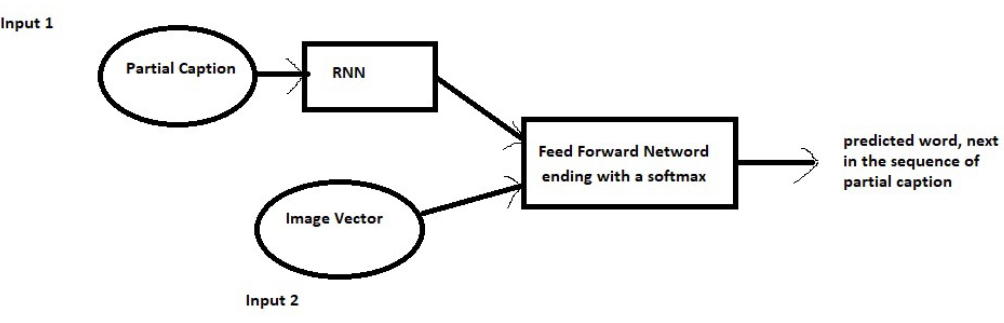

In [104]:
shape_img_feature = (2048,)

#partial caption sequence
input_seq = Input(shape=(max_length_sent, ))
seq1 = Embedding(size_vocab, embedding_dim, mask_zero=True)(input_seq)
seq2 = Dropout(0.5)(seq1)
seq3 = LSTM(256)(seq2)

#image feature extractor
input_fe = Input(shape=shape_img_feature)
fe1 = Dropout(0.5)(input_fe)
fe2 = Dense(256, activation='relu')(fe1)

#decoding
decoder1 = add([fe2, seq3])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(size_vocab, activation='softmax')(decoder2)

model = Model(inputs=[input_fe, input_seq], outputs=output)

In [105]:
model.summary()

model.layers[2]
model.layers[2].set_weights([embeddings_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 200)      410200      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [106]:
epochs = 5
batch_n_images = 5
steps = len(descriptions) // batch_n_images

In [107]:
def data_generator(batch_n_images, features):
    X1, X2, y = list(), list(), list()
    n = 0

    while True:
        for img, captions in descriptions.items():
            img = features.get(img + '.jpg')
            if img is None:
                continue
                
            n += 1

            for caption in captions: #caption is a sentence
                encoded_words = [word2idx[w] for w in caption.split() if w in word2idx]

                for i in range(1, len(encoded_words)): #seq is sequence
                    in_seq, out_seq = encoded_words[:i], encoded_words[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length_sent)[0]
                    out_seq = to_categorical([out_seq], num_classes=size_vocab)[0] #create row = num of vocab
                    
                    X1.append(img)
                    X2.append(in_seq)
                    y.append(out_seq)


            if n == batch_n_images:
                yield [[np.array(X1), np.array(X2)], np.array(y)]                
                X1, X2, y = list(), list(), list()
                n = 0

In [108]:
model.fit(data_generator(batch_n_images, encoded_train_images),
          steps_per_epoch=steps,
          epochs=epochs,
          verbose=1)

Epoch 1/5
1618/1618 [==============================] - 268s 165ms/step - loss: 4.2334
Epoch 2/5
1618/1618 [==============================] - 266s 165ms/step - loss: 3.4960
Epoch 3/5
1618/1618 [==============================] - 265s 164ms/step - loss: 3.2710
Epoch 4/5
1618/1618 [==============================] - 265s 164ms/step - loss: 3.1101
Epoch 5/5
1618/1618 [==============================] - 268s 166ms/step - loss: 3.0072


In [110]:
model.fit(data_generator(batch_n_images, encoded_train_images),
          steps_per_epoch=steps,
          epochs=epochs,
          verbose=1)

Epoch 1/5
1618/1618 [==============================] - 268s 165ms/step - loss: 2.9100
Epoch 2/5
1618/1618 [==============================] - 267s 165ms/step - loss: 2.8433
Epoch 3/5
1618/1618 [==============================] - 265s 164ms/step - loss: 2.8137
Epoch 4/5
1618/1618 [==============================] - 266s 164ms/step - loss: 2.7399
Epoch 5/5
1618/1618 [==============================] - 266s 165ms/step - loss: 2.7069


In [149]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4))
batch_n_images = 2
steps = len(descriptions) // batch_n_images
epochs=2

In [ ]:
model.fit(data_generator(batch_n_images, encoded_train_images),
          steps_per_epoch=steps,
          epochs=epochs,
          verbose=1)

In [146]:
path_weights = 'model_30.h5'
# model.save_weights(path_weights)
model.load_weights(path_weights)

In [158]:
def greedySearch(img):
    text = ['startseq']
    seq = list()

    for i in range(max_length_sent):
        idx = word2idx[text[-1]] if text[-1] in word2idx else None
        if idx:
            seq.append(idx) 
        sequence = pad_sequences([seq], maxlen=max_length_sent)
        pred = model.predict([img, sequence], verbose=0)
        pred = np.argmax(pred)
        pred_word = idx2word[pred]
        text.append(pred_word)
        if pred_word == 'endseq':
            break

    return ' '.join(text[1:-1])

In [128]:
test_images_keys = list(encoded_test_images.keys())

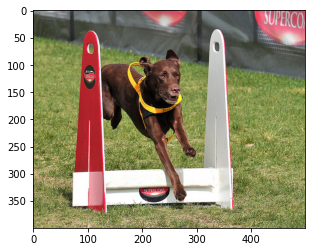

dog is jumping up to catch red frisbee


In [165]:
idx += 10
imgkey = test_images_keys[idx]
encoded_img = encoded_test_images[imgkey].reshape((1, -1))
image = plt.imread(path_img_data + imgkey)
plt.imshow(image)
plt.show()
print(greedySearch(encoded_img))